In [1]:
# importing tools 
import s3fs
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt 
#for removing warnings
import warnings

In [2]:
# open the data with s3fs from the databucket 
fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
data_path1 = 's3://data/CREG12.L75-REF08_mesh_zgr.zarr'
data_path2 = 's3://velocity-u.zarr'
data_path3 = 's3://velocity-v.zarr'

remote_files1 = fsg.glob(data_path1)
remote_files2 = fsg.glob(data_path2)
remote_files3 = fsg.glob(data_path3)

store1 = s3fs.S3Map(root=data_path1, s3=fsg, check=False)
store2 = s3fs.S3Map(root=data_path2, s3=fsg, check=False)
store3 = s3fs.S3Map(root=data_path3, s3=fsg, check=False)

dzz = xr.open_zarr(store=store1, consolidated=True)
du = xr.open_zarr(store=store2, consolidated=True)
dv = xr.open_zarr(store=store3, consolidated=True)

In [3]:
def open_s3fs(path):
    # open the data with s3fs from the databucket 
    fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
    data_path = f's3://data/{path}'
    remote_files = fsg.glob(data_path)
    fileset = [fsg.open(file) for file in remote_files]
    #open the dataset 
    dset = xr.open_mfdataset(fileset, 
                             #combine='by_coords',
                             compat='override')
    return dset

In [4]:
scalar = open_s3fs('CREG12.L75-REF08_mesh_hgr.nc')

In [5]:
p_list = [(31.13247,81.24202),
          (31.13533,81.24255),
          (31.14506,81.24587)
          ,(011.1189, 69.5289),
          (013.16845,68.58759),
          (013.19866,68.56109),
          (012.45082,68.50128),
          (5.57541,79.37209),
          (5.48733,80.03876),
          (5.56333,79.44093),
          (-160.4923,72.121),
          (-159.1216,72.1628),
          (-158.5512,72.1815),
          (-163.5346,72.2808),
          (-164.0992,72.5252)]
moor_l = [(836, 440),
            (838, 440),
            (836, 439),
            (915, 157),
            (930, 149),
            (932, 147),
            (929, 142),
            (774, 344),
            (766, 358),
            (773, 346),
            (334, 978),
            (334, 978),
            (334, 978),
            (334, 978),
            (409, 992), 
            (399, 987), 
            (395, 985), 
            (434, 997), 
            (440, 993)]
c_list = ['c', 'orangered', 'g',
          'r', 'm', 'y','tab:orange',
          'tab:pink', 'limegreen', 'maroon', 
          'dodgerblue', 'gold', 'peru','deeppink',
          'gold','peru','dodgerblue','c','m']

In [6]:
u = du.vozocrtx.isel(x=slice(200,1400),y=slice(650,1800))
u = u.rename({'depthu' : 'depth'})
v = dv.vomecrty.isel(x=slice(200,1400),y=slice(650,1800))
v = v.rename({'depthv' : 'depth'})

bathym = dzz.mbathy.isel(x=slice(200,1400),y=slice(650,1800)).squeeze(axis=0)

zonal = scalar.glamt.isel(x=slice(200,1399),y=slice(650,1799)).squeeze(axis=0)
merd = scalar.gphit.isel(x=slice(200,1399),y=slice(650,1799)).squeeze(axis=0)

In [7]:
d_hbx = bathym.isel(y=slice(0,1149)).diff(dim='x')
d_hby = bathym.isel(x=slice(0,1199)).diff(dim='y')

len_bat = np.sqrt((d_hbx/zonal)**2 + (d_hby/merd)**2)

d_hbxg = d_hbx.rolling(x = 10,).mean()
d_hbyg = d_hby.rolling(y = 10,).mean()

len_batg = np.sqrt((d_hbxg/zonal)**2 + (d_hbyg/merd)**2)

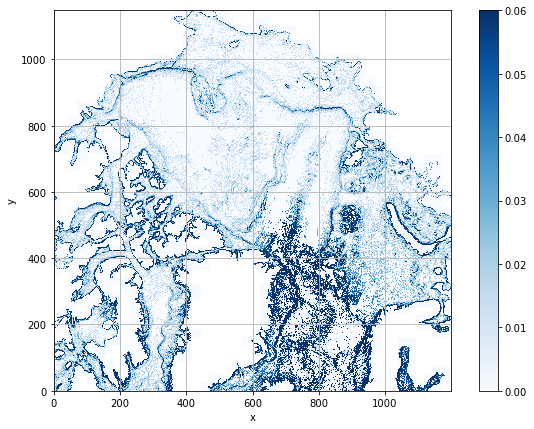

In [10]:
fig, ax = plt.subplots(figsize=(10,7))

cmap = plt.get_cmap('Blues')
c = len_bat.plot(vmin=0, vmax=0.06, cmap=cmap, add_colorbar=False)
#for i,p in enumerate(moor_l):
#    ax.plot(p[0], p[1], marker='o', color=c_list[i])
fig.colorbar(c,
             shrink=1,
             #label=r"Depth [m]"
            )
ax.grid('on')
ax.set_aspect('equal')

In [ ]:
def PCz_20(x,y):
    'Finding the level the given location dosent have values for anymore'

    d = bathym.isel(x=x, y=y).values

    dypu = u.isel(x=x, y=y, depth = slice(15,d-1)) # -1 pga d=0 og vi vil en opp der vi har bunnhastigheter
    dypv = v.isel(x=x, y=y, depth = slice(15,d-1))
    
    covu = np.cov(dypu.T, bias=True) # uten .T ble den en 73x73 matrise 
    values_u, vectors_u = np.linalg.eig(covu)
    order_u = values_u.argsort()[::-1]
    values_u, vectors_u = values_u[order_u], vectors_u[:, order_u]
    
    covv = np.cov(dypv.T, bias=True) # uten .T ble den en 73x73 matrise 
    values_v, vectors_v = np.linalg.eig(covv)
    order_v = values_v.argsort()[::-1]
    values_v, vectors_v = values_v[order_v], vectors_v[:, order_v]
    
    PC1u = (np.sqrt(values_u[0])*vectors_u[:,0])
    PC1v = (np.sqrt(values_v[0])*vectors_v[:,0])
    PC2u = (np.sqrt(values_u[1])*vectors_u[:,1])
    PC2v = (np.sqrt(values_v[1])*vectors_v[:,1])
    
    PVE1p = int(round(values_u[0]/np.sum(values_u)*100,0))
    PVE1o = int(round(values_v[0]/np.sum(values_v)*100,0))
    PVE2p = int(round(values_u[1]/np.sum(values_u)*100,0))
    PVE2o = int(round(values_v[1]/np.sum(values_v)*100,0))
    
    return PC1u, PC1v, PC2u, PC2v, dypu, dypv, PVE1u, PVE1v, PVE2u, PVE2v

In [8]:
def PCz(x,y):
    'Finding the level the given location dosent have values for anymore'

    d = bathym.isel(x=x, y=y).values

    dypu = u.isel(x=x, y=y, depth = slice(0,d-1)) # -1 pga d=0 og vi vil en opp der vi har bunnhastigheter
    dypv = v.isel(x=x, y=y, depth = slice(0,d-1))
    
    covu = np.cov(dypu.T, bias=True) # uten .T ble den en 73x73 matrise 
    values_u, vectors_u = np.linalg.eig(covu)
    order_u = values_u.argsort()[::-1]
    values_u, vectors_u = values_u[order_u], vectors_u[:, order_u]
    
    covv = np.cov(dypv.T, bias=True) # uten .T ble den en 73x73 matrise 
    values_v, vectors_v = np.linalg.eig(covv)
    order_v = values_v.argsort()[::-1]
    values_v, vectors_v = values_v[order_v], vectors_v[:, order_v]
    
    PC1u = (np.sqrt(values_u[0])*vectors_u[:,0])
    PC1v = (np.sqrt(values_v[0])*vectors_v[:,0])
    PC2u = (np.sqrt(values_u[1])*vectors_u[:,1])
    PC2v = (np.sqrt(values_v[1])*vectors_v[:,1])
    
    PVE1u = int(round(values_u[0]/np.sum(values_u)*100,0))
    PVE1v = int(round(values_v[0]/np.sum(values_v)*100,0))
    PVE2u = int(round(values_u[1]/np.sum(values_u)*100,0))
    PVE2v = int(round(values_v[1]/np.sum(values_v)*100,0))
    
    return PC1u, PC1v, PC2u, PC2v, dypu, dypv, PVE1u, PVE1v, PVE2u, PVE2v

In [14]:
'Making a function for the vertical PC'
def PCz_op(x,y):
    up = u.isel(y=y, x=x)
    vp = v.isel(y=y, x=x)
    
    b = d_hbxg.isel(x=x,y=y)/zonal.isel(x=x,y=y)
    d = d_hbyg.isel(x=x,y=y)/merd.isel(x=x,y=y)
    
    vel_par = (up*b + vp*d)/(np.sqrt(b**2 + d**2))
    vel_ort = (up*d - vp*b)/(np.sqrt(b**2 + d**2))
    
    # lag lengde scalar av bathym og dele u_o og u_p på 

    #vel_ort = ((up*(d_hbx_p/zonalp) + vp*(d_hby_p/merdp))/np.sqrt((d_hbx_p/zonalp)**2 + (d_hby_p/merdp)**2)) 
    #vel_par = ((up*(d_hby_p/merdp)  - vp*(d_hbx_p/zonalp))/np.sqrt((d_hbx_p/zonalp)**2 + (d_hby_p/merdp)**2))
    
    d_p = bathym.isel(y=y, x=x).values
    dyp_o = vel_ort.isel(depth = slice(0,int(d_p)-1)) # -1 pga d=0 og vi vil en opp der vi har bunnhastigheter
    dyp_p = vel_par.isel(depth = slice(0,int(d_p)-1))

    cov_o = np.cov(dyp_o.T, bias=True) # uten .T ble den en 73x73 matrise 
    cov_p = np.cov(dyp_p.T, bias=True)
    
    values_o, vectors_o = np.linalg.eig(cov_o)
    order_o = values_o.argsort()[::-1]
    values_o, vectors_o = values_o[order_o], vectors_o[:, order_o]
    values_p, vectors_p = np.linalg.eig(cov_p)
    order_p = values_p.argsort()[::-1]
    values_p, vectors_p = values_p[order_p], vectors_p[:, order_p]
    
    PC1p = (np.sqrt(values_p[0])*vectors_p[:,0])
    PC1o = (np.sqrt(values_o[0])*vectors_o[:,0])
    PC2p = (np.sqrt(values_p[1])*vectors_p[:,1])
    PC2o = (np.sqrt(values_o[1])*vectors_o[:,1])
    
    PVE1p = int(round(values_p[0]/np.sum(values_p)*100,0))
    PVE1o = int(round(values_o[0]/np.sum(values_o)*100,0))
    PVE2p = int(round(values_p[1]/np.sum(values_p)*100,0))
    PVE2o = int(round(values_o[1]/np.sum(values_o)*100,0))
    
    return PC1p, PC1o, PC2p, PC2o, dyp_p, dyp_o, PVE1p, PVE1o, PVE2p, PVE2o

## Barents Sea

922 157


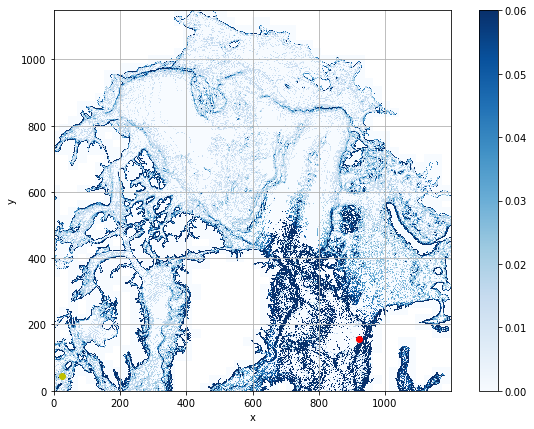

In [118]:
lof = [(915, 157),(935, 143),(938, 144),(934, 141)]
fig, ax = plt.subplots(figsize=(10,7))
p = (922, 157)
print(p[0], p[1])

cmap = plt.get_cmap(cmocean.cm.deep)
c = len_bat.plot(vmin=0, vmax=0.06, cmap=cmap, add_colorbar=False) #.isel(x=slice(900,1100),y=slice(0,200))
ax.plot(p[0], p[1], marker='o', color='r')
ax.plot(26, 45, marker='o', color='y')
fig.colorbar(c,
             shrink=1,
             #label=r"Depth [m]"
            )
ax.grid('on')
ax.set_aspect('equal')

836 440
838 440
836 439


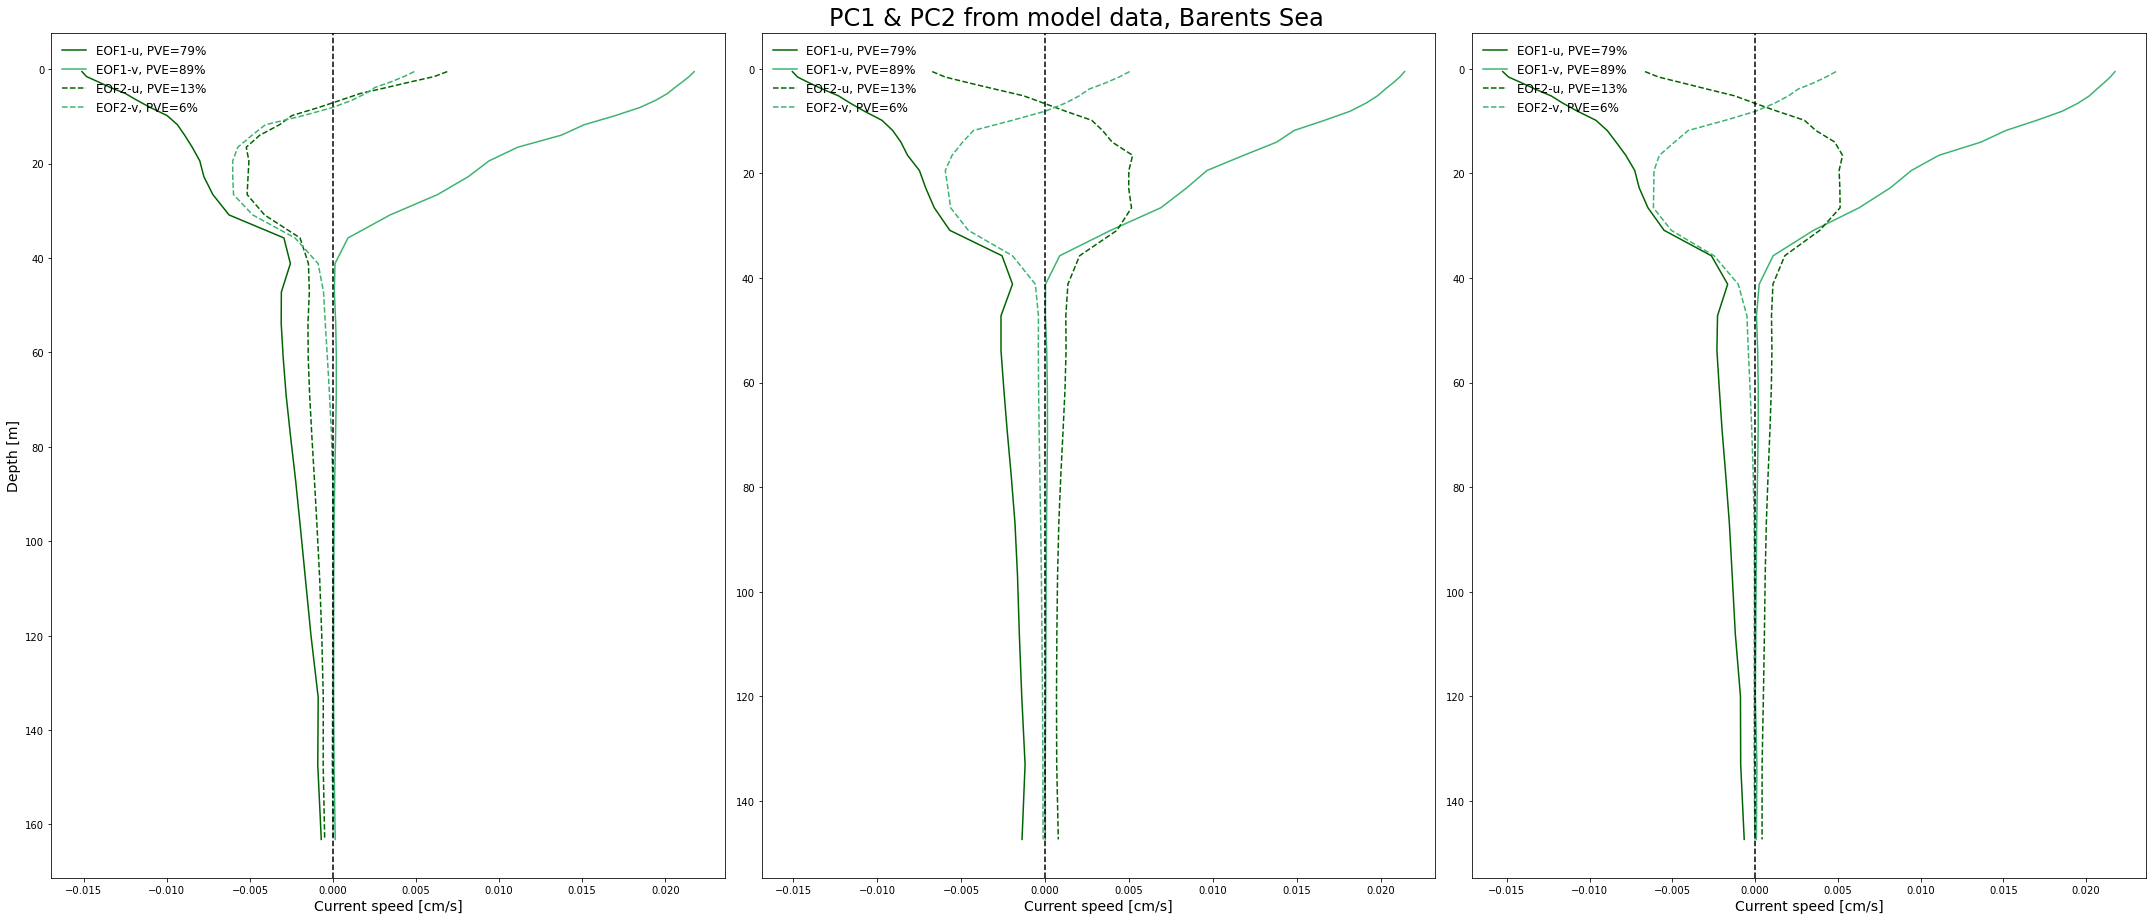

In [15]:
warnings.simplefilter("ignore")
fig, axes = plt.subplots(1,3,figsize = (30,13))
plt.suptitle('PC1 & PC2 from model data, Barents Sea', 
             horizontalalignment='center',
            fontsize=24)
bar = [(836, 440),(826, 445),(836, 439)]
axes[0].set_ylabel('Depth [m]', fontsize=14)

for axs, p in zip(axes.flat, range(len(bar))):
    pp = moor_l[p]
    print(pp[0], pp[1])    
    PC1u, PC1v, PC2u, PC2v, dypu, dypv, PVE1u, PVE1v, PVE2u, PVE2v = PCz(pp[0],pp[1])
        
    axs.plot(PC1u,dypu.depth, 'darkgreen', label = f'EOF1-u, PVE={PVE1u}%')
    axs.plot(PC1v,dypv.depth, 'mediumseagreen', label= f'EOF1-v, PVE={PVE1v}%')
    axs.plot(PC2u,dypu.depth, 'darkgreen', linestyle = '--', label = f'EOF2-u, PVE={PVE2u}%')
    axs.plot(PC2v,dypv.depth, 'mediumseagreen', linestyle = '--', label= f'EOF2-v, PVE={PVE2v}%')
    axs.axvline(0, color='k', linestyle = '--')
    axs.legend(frameon=False, fontsize=12, loc="upper left") 
    axs.invert_yaxis()
    axs.set_xlabel('Current speed [cm/s]', fontsize=14)
fig.tight_layout()   

plt.savefig('EOF_Yermark_mod.pdf', dpi = 300)

836 440
838 440
836 439


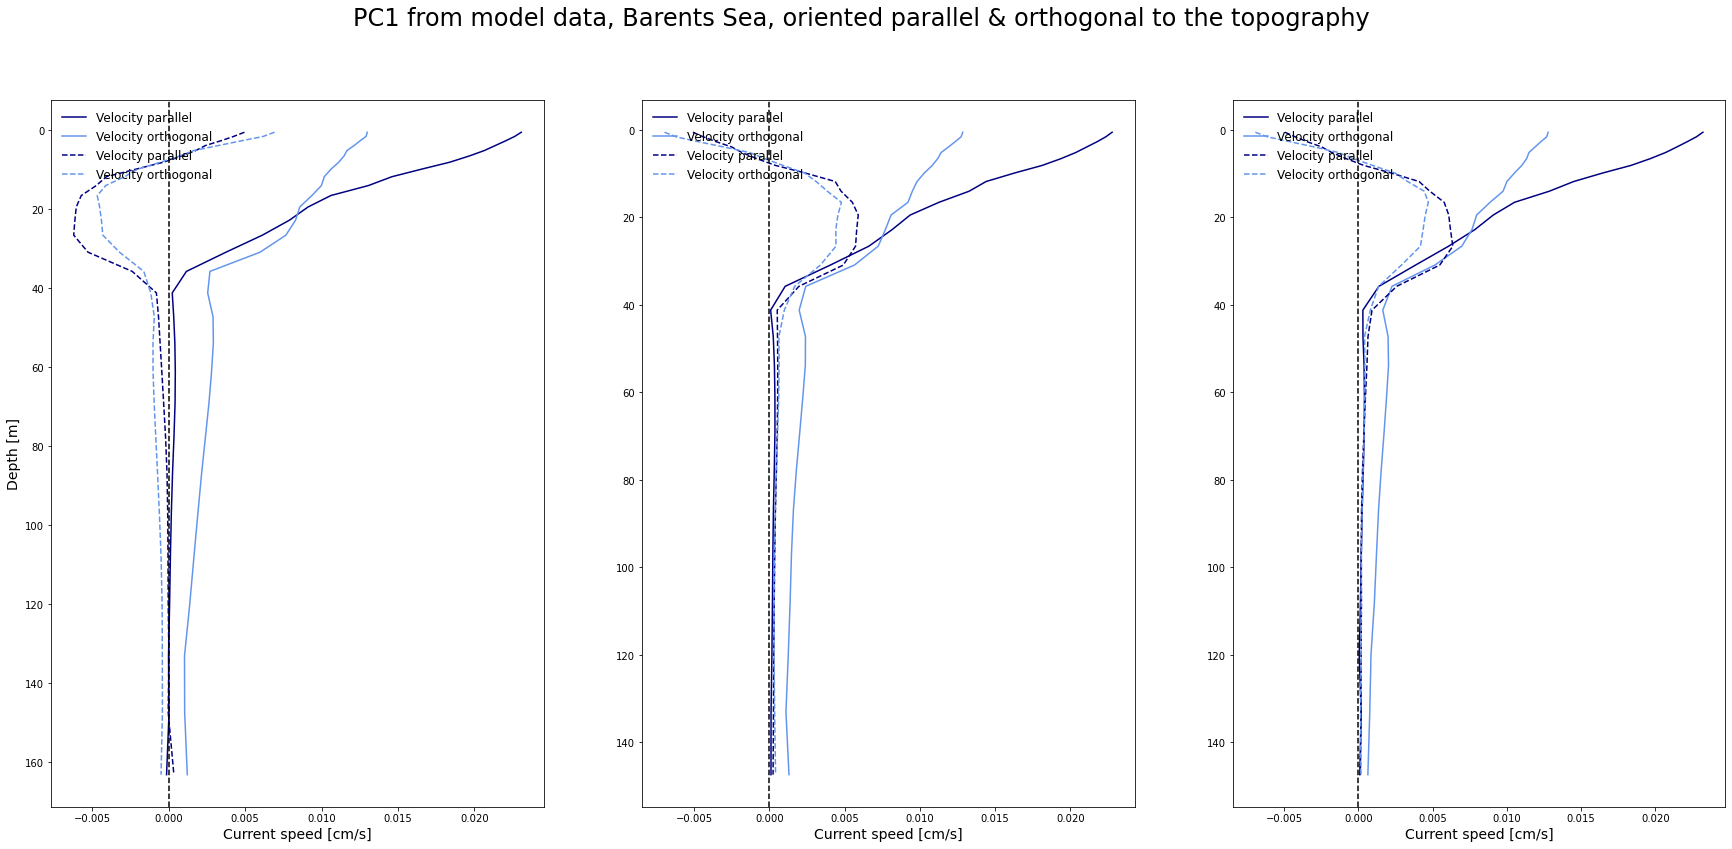

In [82]:
warnings.simplefilter("ignore")
fig, axes = plt.subplots(1,3,figsize = (30,13))
plt.suptitle('EOF from model data, Barents Sea, oriented $||$ & $\perp$ to the topography', 
             horizontalalignment='center',
            fontsize=24)
bar = [(836, 440),(838, 440),(836, 439)]
axes[0].set_ylabel('Depth [m]', fontsize=14)

for axs, p in zip(axes.flat, range(len(bar))):
    pp = moor_l[p]
    print(pp[0], pp[1])    
    PC1p, PC1o, PC2p, PC2o, dypp, dypo, PVE1p, PVE1o, PVE2p, PVE2o = PCz_op(pp[0],pp[1])
        
    axs.plot(PC1p,dypp.depth, 'navy', label = f'EOF1$||$, PVE={PVE1p}%')
    axs.plot(PC1o,dypo.depth, 'cornflowerblue', label = f'EOF1$\perp$, PVE={PVE1o}%')
    axs.plot(PC2p,dypp.depth, 'navy', linestyle = '--', label = f'EOF2$||$, PVE={PVE2p}%')
    axs.plot(PC2o,dypo.depth, 'cornflowerblue', linestyle = '--', label = f'EOF2$\perp$, PVE={PVE2p}%')
    axs.axvline(0, color='k', linestyle = '--')
    axs.legend(frameon=False, fontsize=10, loc="upper left") 
    axs.invert_yaxis()
    axs.set_xlabel('Current speed [cm/s]', fontsize=14)

#fig.tight_layout()   

plt.savefig('EOF_Barents_mod_topo.pdf', dpi = 300)

## Lofoten Basin 

In [9]:
lof = [(923, 157),(930, 149),(932, 147),(929, 142)] #(915, 157)

923 157
930 149
932 147
929 142


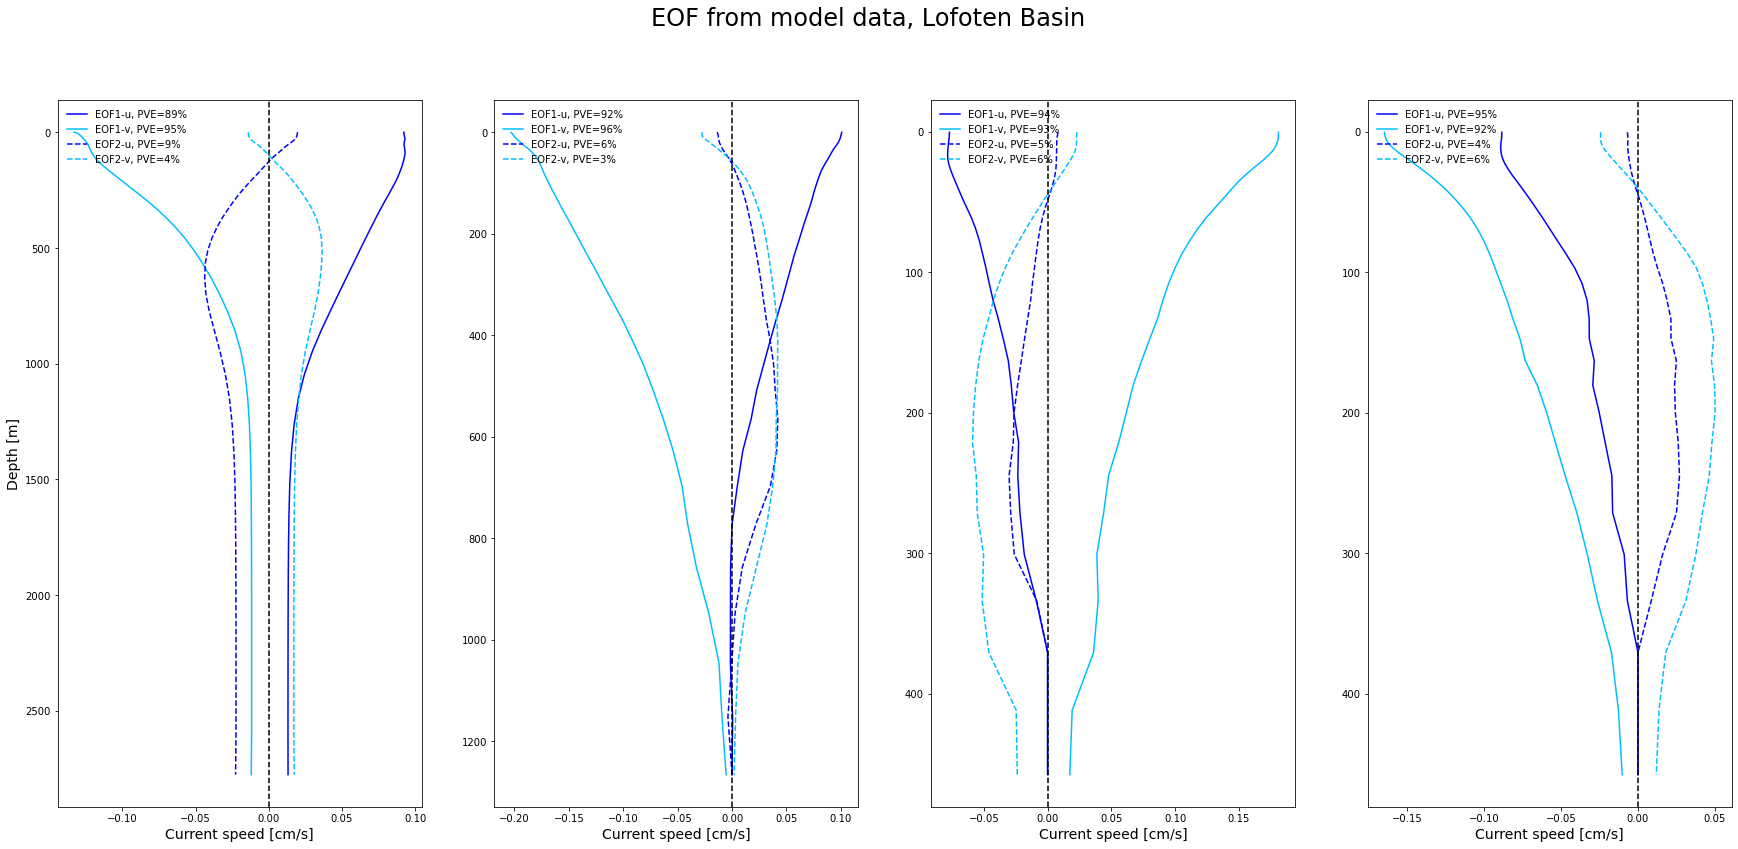

In [10]:
warnings.simplefilter("ignore")
fig, axes = plt.subplots(1,4,figsize = (30,13))
plt.suptitle('EOF from model data, Lofoten Basin', 
             horizontalalignment='center',
            fontsize=24)
axes[0].set_ylabel('Depth [m]', fontsize=14)

for axs, p in zip(axes.flat, range(len(lof))):
    pp = lof[p]
    print(pp[0], pp[1])    
    PC1u, PC1v, PC2u, PC2v, dypu, dypv, PVE1u, PVE1v, PVE2u, PVE2v = PCz(pp[0],pp[1])
        
    axs.plot(PC1u,dypu.depth, 'b', label = f'EOF1-u, PVE={PVE1u}%')
    axs.plot(PC1v,dypv.depth, 'deepskyblue', label= f'EOF1-v, PVE={PVE1v}%')
    axs.plot(PC2u,dypu.depth, 'b', linestyle = '--', label = f'EOF2-u, PVE={PVE2u}%')
    axs.plot(PC2v,dypv.depth, 'deepskyblue', linestyle = '--', label= f'EOF2-v, PVE={PVE2v}%')
    axs.axvline(0, color='k', linestyle = '--')
    axs.legend(frameon=False, fontsize=10, loc="upper left") 
    axs.invert_yaxis()
    axs.set_xlabel('Current speed [cm/s]', fontsize=14)
    
plt.savefig('EOF_Lofoten_mod.pdf', dpi = 300)

## Figur:

# MB
EOF1 from MB, declie faster towards zero in the upper 500 meter

923 157
935 143
938 144


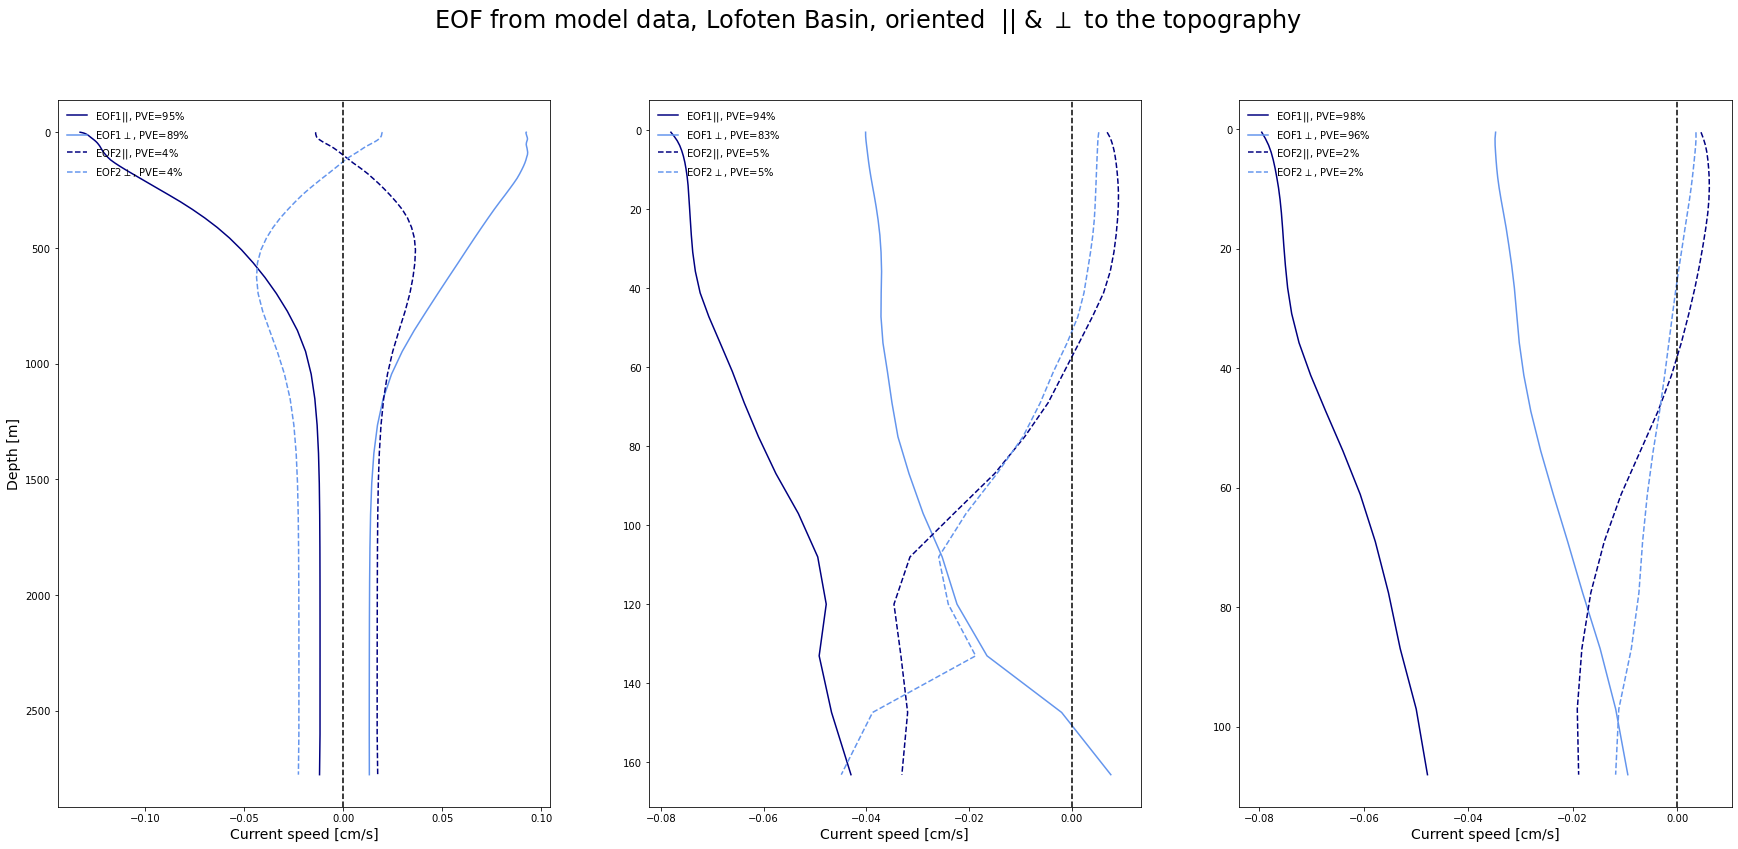

In [137]:
warnings.simplefilter("ignore")
fig, axes = plt.subplots(1,4,figsize = (30,13))
plt.suptitle('EOF from model data, Lofoten Basin, oriented  $||$ & $\perp$ to the topography', 
             horizontalalignment='center',
            fontsize=24)

axes[0].set_ylabel('Depth [m]', fontsize=14)

for axs, p in zip(axes.flat, range(len(lof))):
    pp = lof[p]
    print(pp[0], pp[1])    
    PC1p, PC1o, PC2p, PC2o, dypp, dypo, PVE1p, PVE1o, PVE2p, PVE2o = PCz_op(pp[0],pp[1])
        
    axs.plot(PC1p,dypp.depth, 'navy', label = f'EOF1$||$, PVE={PVE1p}%')
    axs.plot(PC1o,dypo.depth, 'cornflowerblue', label = f'EOF1$\perp$, PVE={PVE1o}%')
    axs.plot(PC2p,dypp.depth, 'navy', linestyle = '--', label = f'EOF2$||$, PVE={PVE2p}%')
    axs.plot(PC2o,dypo.depth, 'cornflowerblue', linestyle = '--', label = f'EOF2$\perp$, PVE={PVE2p}%')
    axs.axvline(0, color='k', linestyle = '--')
    axs.legend(frameon=False, fontsize=10, loc="upper left") 
    axs.invert_yaxis()
    axs.set_xlabel('Current speed [cm/s]', fontsize=14)

#fig.tight_layout()   

plt.savefig('EOF_Lofoten_mod_topo.pdf', dpi = 300)

## Yermark shelf

In [11]:
yer = [(774, 344),(766, 358),(773, 346)]

In [ ]:
warnings.simplefilter("ignore")
fig, axes = plt.subplots(1,3,figsize = (30,13))
plt.suptitle('EOF from model data, Yermark Shelf', 
             horizontalalignment='center',
            fontsize=24)
axes[0].set_ylabel('Depth [m]', fontsize=14)

for axs, p in zip(axes.flat, range(len(yer))):
    pp = yer[p]
    print(pp[0], pp[1])    
    PC1u, PC1v, PC2u, PC2v, dypu, dypv, PVE1u, PVE1v, PVE2u, PVE2v = PCz(pp[0],pp[1])
        
    axs.plot(PC1u,dypu.depth, 'b', label = f'EOF1-u, PVE={PVE1u}%')
    axs.plot(PC1v,dypv.depth, 'deepskyblue', label= f'EOF1-v, PVE={PVE1v}%')
    axs.plot(PC2u,dypu.depth, 'b', linestyle = '--', label = f'EOF2-u, PVE={PVE2u}%')
    axs.plot(PC2v,dypv.depth, 'deepskyblue', linestyle = '--', label= f'EOF2-v, PVE={PVE2v}%')
    axs.axvline(0, color='k', linestyle = '--')
    axs.legend(frameon=False, fontsize=10, loc="upper left") 
    axs.invert_yaxis()
    axs.set_xlabel('Current speed [cm/s]', fontsize=14)

plt.savefig('EOF_Yermark_mod.pdf', dpi = 300)

774 344


In [ ]:
warnings.simplefilter("ignore")
fig, axes = plt.subplots(1,3,figsize = (30,13))
plt.suptitle('EOF from model data, Yermark Shelf', 
             horizontalalignment='center',
            fontsize=24)
axes[0].set_ylabel('Depth [m]', fontsize=14)

for axs, p in zip(axes.flat, range(len(yer))):
    pp = yer[p]
    print(pp[0], pp[1]+6)    
    PC1u, PC1v, PC2u, PC2v, dypu, dypv, PVE1u, PVE1v, PVE2u, PVE2v = PCz(pp[0],pp[1]+6)
        
    axs.plot(PC1u,dypu.depth, 'b', label = f'EOF1-u, PVE={PVE1u}%')
    axs.plot(PC1v,dypv.depth, 'deepskyblue', label= f'EOF1-v, PVE={PVE1v}%')
    axs.plot(PC2u,dypu.depth, 'b', linestyle = '--', label = f'EOF2-u, PVE={PVE2u}%')
    axs.plot(PC2v,dypv.depth, 'deepskyblue', linestyle = '--', label= f'EOF2-v, PVE={PVE2v}%')
    axs.axvline(0, color='k', linestyle = '--')
    axs.legend(frameon=False, fontsize=10, loc="upper left") 
    axs.invert_yaxis()
    axs.set_xlabel('Current speed [cm/s]', fontsize=14)

plt.savefig('EOF_Yermark_mod.pdf', dpi = 300)

774 344
766 358
773 346


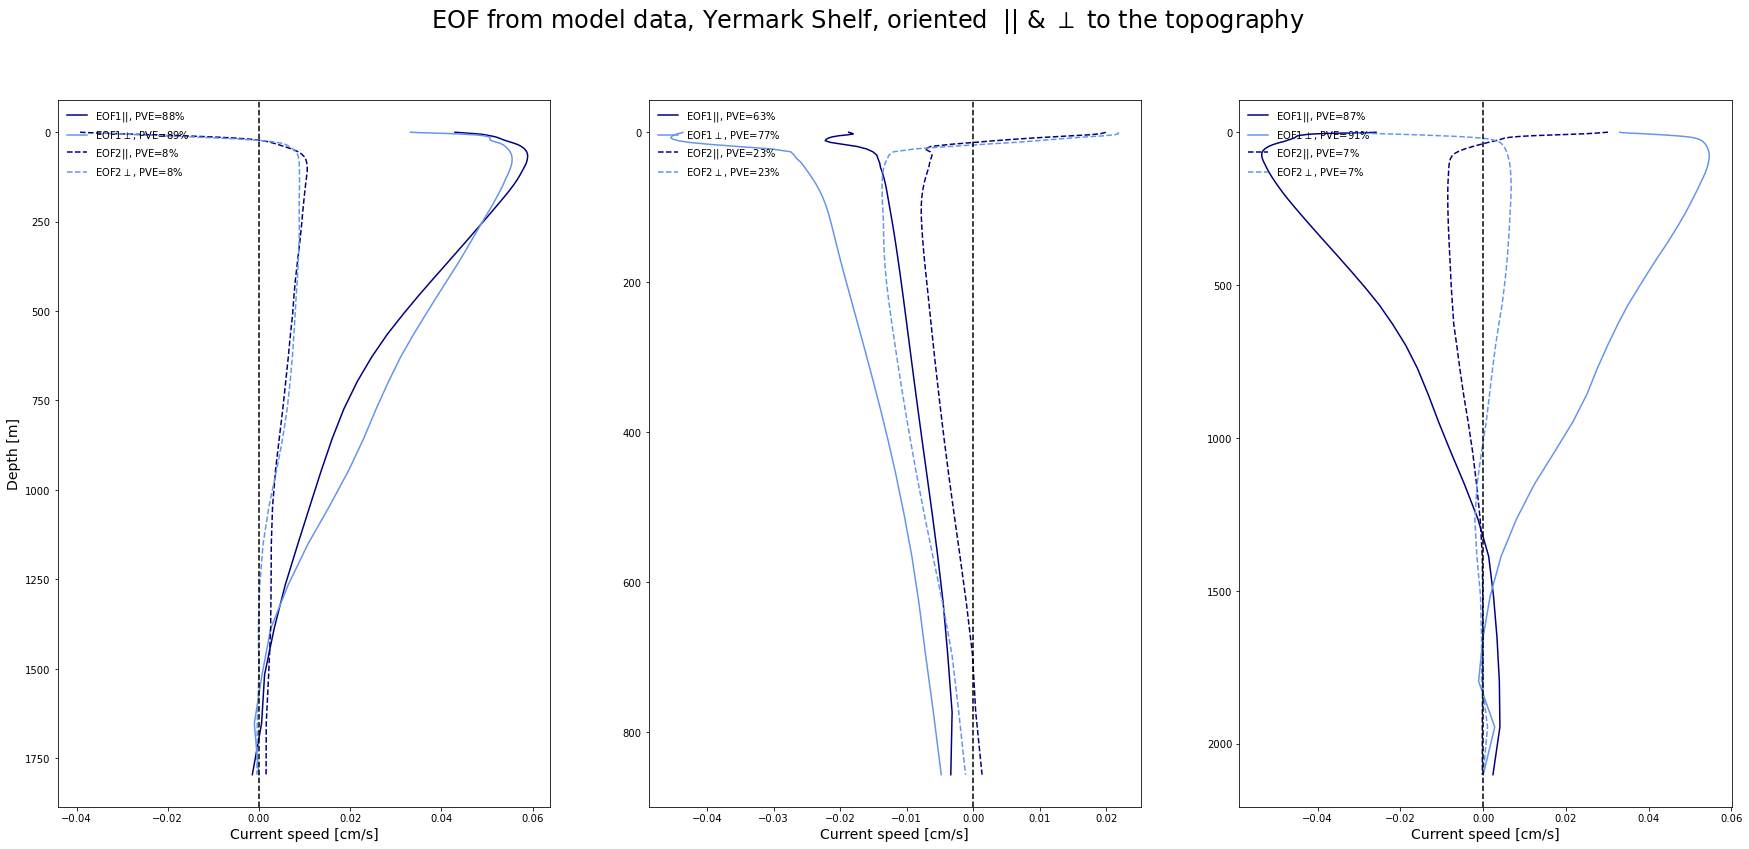

In [146]:
warnings.simplefilter("ignore")
fig, axes = plt.subplots(1,3,figsize = (30,13))
plt.suptitle('EOF from model data, Yermark Shelf, oriented  $||$ & $\perp$ to the topography', 
             horizontalalignment='center',
            fontsize=24)
axes[0].set_ylabel('Depth [m]', fontsize=14)

for axs, p in zip(axes.flat, range(len(yer))):
    pp = yer[p]
    print(pp[0], pp[1])    
    PC1p, PC1o, PC2p, PC2o, dypp, dypo, PVE1p, PVE1o, PVE2p, PVE2o = PCz_op(pp[0],pp[1])
        
    axs.plot(PC1p,dypp.depth, 'navy', label = f'EOF1$||$, PVE={PVE1p}%')
    axs.plot(PC1o,dypo.depth, 'cornflowerblue', label = f'EOF1$\perp$, PVE={PVE1o}%')
    axs.plot(PC2p,dypp.depth, 'navy', linestyle = '--', label = f'EOF2$||$, PVE={PVE2p}%')
    axs.plot(PC2o,dypo.depth, 'cornflowerblue', linestyle = '--', label = f'EOF2$\perp$, PVE={PVE2p}%')
    axs.axvline(0, color='k', linestyle = '--')
    axs.legend(frameon=False, fontsize=10, loc="upper left") 
    axs.invert_yaxis()
    axs.set_xlabel('Current speed [cm/s]', fontsize=14)

#fig.tight_layout()   

plt.savefig('EOF_Yermark_mod_topo.pdf', dpi = 300)

## Beaufort Sea

In [147]:
bea = [(334, 978)]#, (334, 978), (334, 978), (334, 978)]

334 978


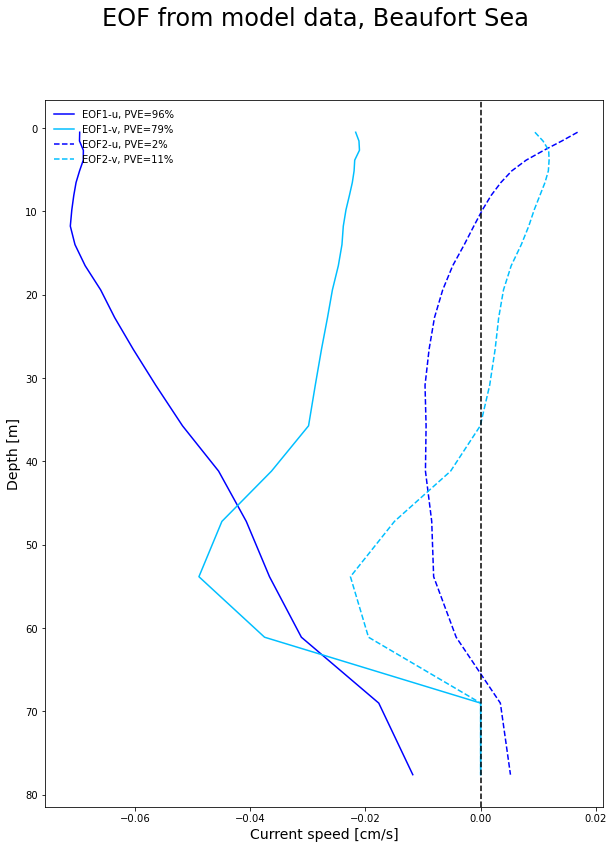

In [155]:
warnings.simplefilter("ignore")
fig, axs = plt.subplots(1,1,figsize = (10,13))
plt.suptitle('EOF from model data, Beaufort Sea', 
             horizontalalignment='center',
            fontsize=24)
axs.set_ylabel('Depth [m]', fontsize=14)

pp = bea[0]
print(pp[0], pp[1])    
PC1u, PC1v, PC2u, PC2v, dypu, dypv, PVE1u, PVE1v, PVE2u, PVE2v = PCz(pp[0],pp[1])

axs.plot(PC1u,dypu.depth, 'b', label = f'EOF1-u, PVE={PVE1u}%')
axs.plot(PC1v,dypv.depth, 'deepskyblue', label= f'EOF1-v, PVE={PVE1v}%')
axs.plot(PC2u,dypu.depth, 'b', linestyle = '--', label = f'EOF2-u, PVE={PVE2u}%')
axs.plot(PC2v,dypv.depth, 'deepskyblue', linestyle = '--', label= f'EOF2-v, PVE={PVE2v}%')
axs.axvline(0, color='k', linestyle = '--')
axs.legend(frameon=False, fontsize=10, loc="upper left") 
axs.invert_yaxis()
axs.set_xlabel('Current speed [cm/s]', fontsize=14)

plt.savefig('EOF_Beaufort_mod.pdf', dpi = 300)

334 978


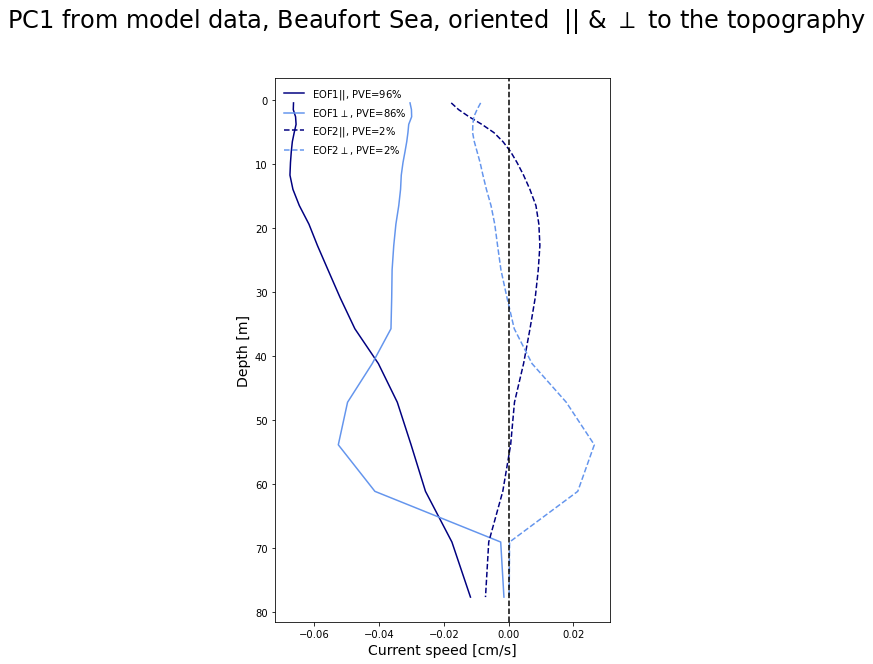

In [156]:
warnings.simplefilter("ignore")
fig, axs = plt.subplots(1,1,figsize = (6,10))
plt.suptitle('PC1 from model data, Beaufort Sea, oriented  $||$ & $\perp$ to the topography', 
             horizontalalignment='center',
            fontsize=24)
axs.set_ylabel('Depth [m]', fontsize=14)

pp = bea[p]
print(pp[0], pp[1])    
PC1p, PC1o, PC2p, PC2o, dypp, dypo, PVE1p, PVE1o, PVE2p, PVE2o = PCz_op(pp[0],pp[1])

axs.plot(PC1p,dypp.depth, 'navy', label = f'EOF1$||$, PVE={PVE1p}%')
axs.plot(PC1o,dypo.depth, 'cornflowerblue', label = f'EOF1$\perp$, PVE={PVE1o}%')
axs.plot(PC2p,dypp.depth, 'navy', linestyle = '--', label = f'EOF2$||$, PVE={PVE2p}%')
axs.plot(PC2o,dypo.depth, 'cornflowerblue', linestyle = '--', label = f'EOF2$\perp$, PVE={PVE2p}%')
axs.axvline(0, color='k', linestyle = '--')
axs.legend(frameon=False, fontsize=10, loc="upper left") 
axs.invert_yaxis()
axs.set_xlabel('Current speed [cm/s]', fontsize=14)

#fig.tight_layout()   

plt.savefig('EOF_Beaufort_mod_topo.pdf', dpi = 300)

## Chuckchi Sea

In [157]:
chi = [(409, 992), (399, 987), (395, 985), (434, 997), (440, 993)]

409 992
399 987
395 985
434 997
440 993


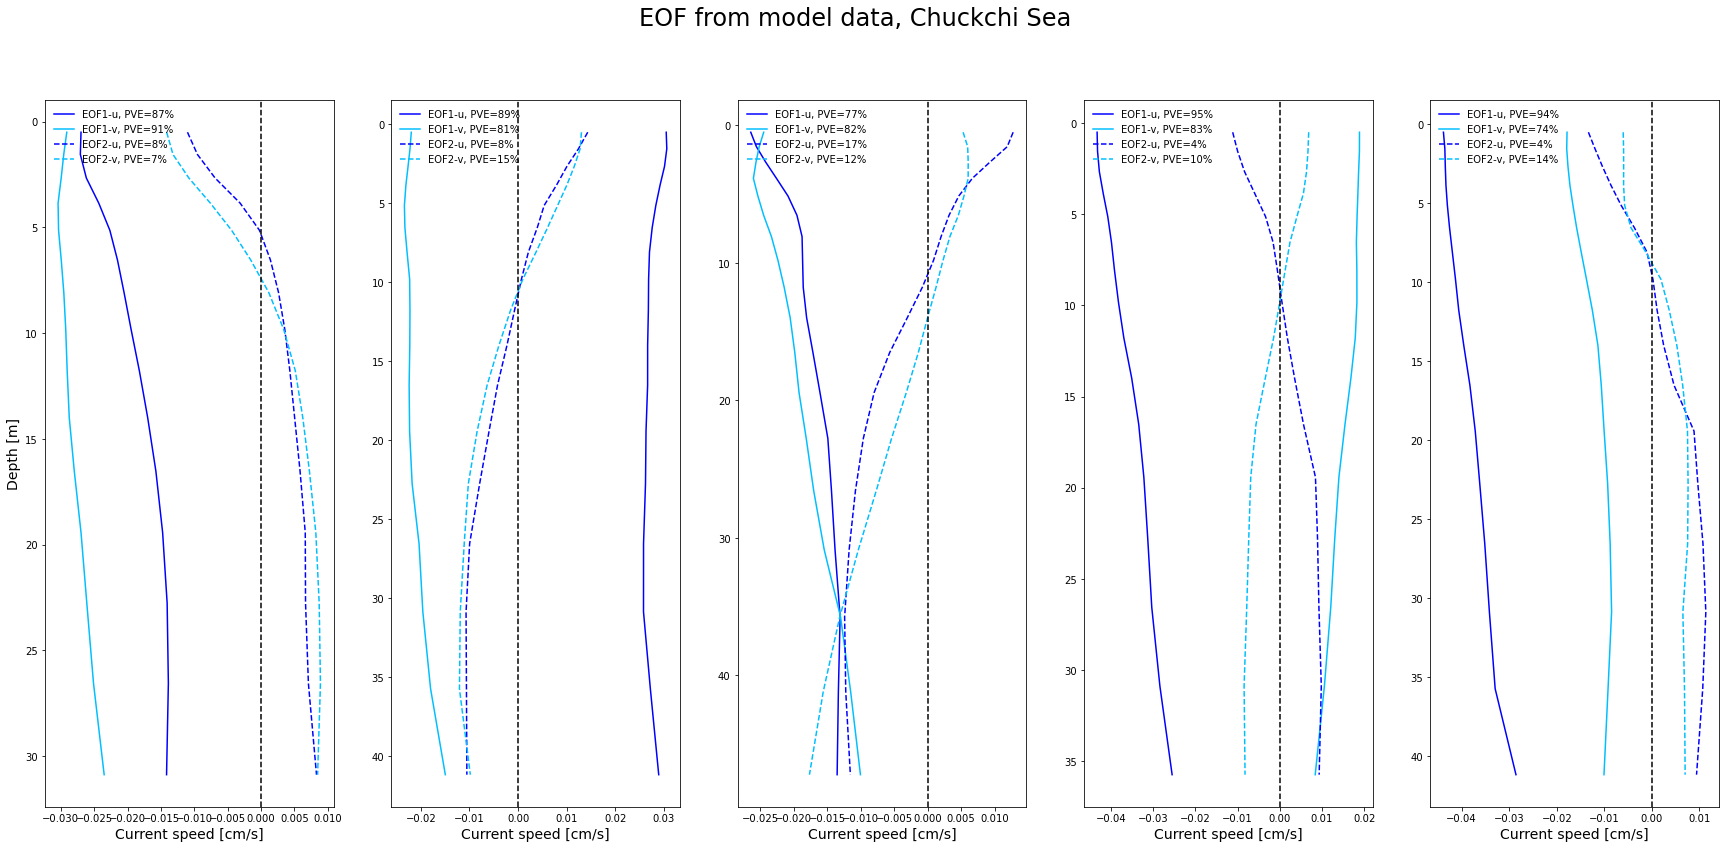

In [161]:
warnings.simplefilter("ignore")
fig, axes = plt.subplots(1,5,figsize = (30,13))
plt.suptitle('EOF from model data, Chuckchi Sea', 
             horizontalalignment='center',
            fontsize=24)
axes[0].set_ylabel('Depth [m]', fontsize=14)

for axs, p in zip(axes.flat, range(len(chi))):
    pp = chi[p]
    print(pp[0], pp[1])         
    PC1u, PC1v, PC2u, PC2v, dypu, dypv, PVE1u, PVE1v, PVE2u, PVE2v = PCz(pp[0],pp[1])
        
    axs.plot(PC1u,dypu.depth, 'b', label = f'EOF1-u, PVE={PVE1u}%')
    axs.plot(PC1v,dypv.depth, 'deepskyblue', label= f'EOF1-v, PVE={PVE1v}%')
    axs.plot(PC2u,dypu.depth, 'b', linestyle = '--', label = f'EOF2-u, PVE={PVE2u}%')
    axs.plot(PC2v,dypv.depth, 'deepskyblue', linestyle = '--', label= f'EOF2-v, PVE={PVE2v}%')
    axs.axvline(0, color='k', linestyle = '--')
    axs.legend(frameon=False, fontsize=10, loc="upper left") 
    axs.invert_yaxis()
    axs.set_xlabel('Current speed [cm/s]', fontsize=14)
    
plt.savefig('EOF_Chuckchi_mod.pdf', dpi = 300)

NameError: name 'chi' is not defined

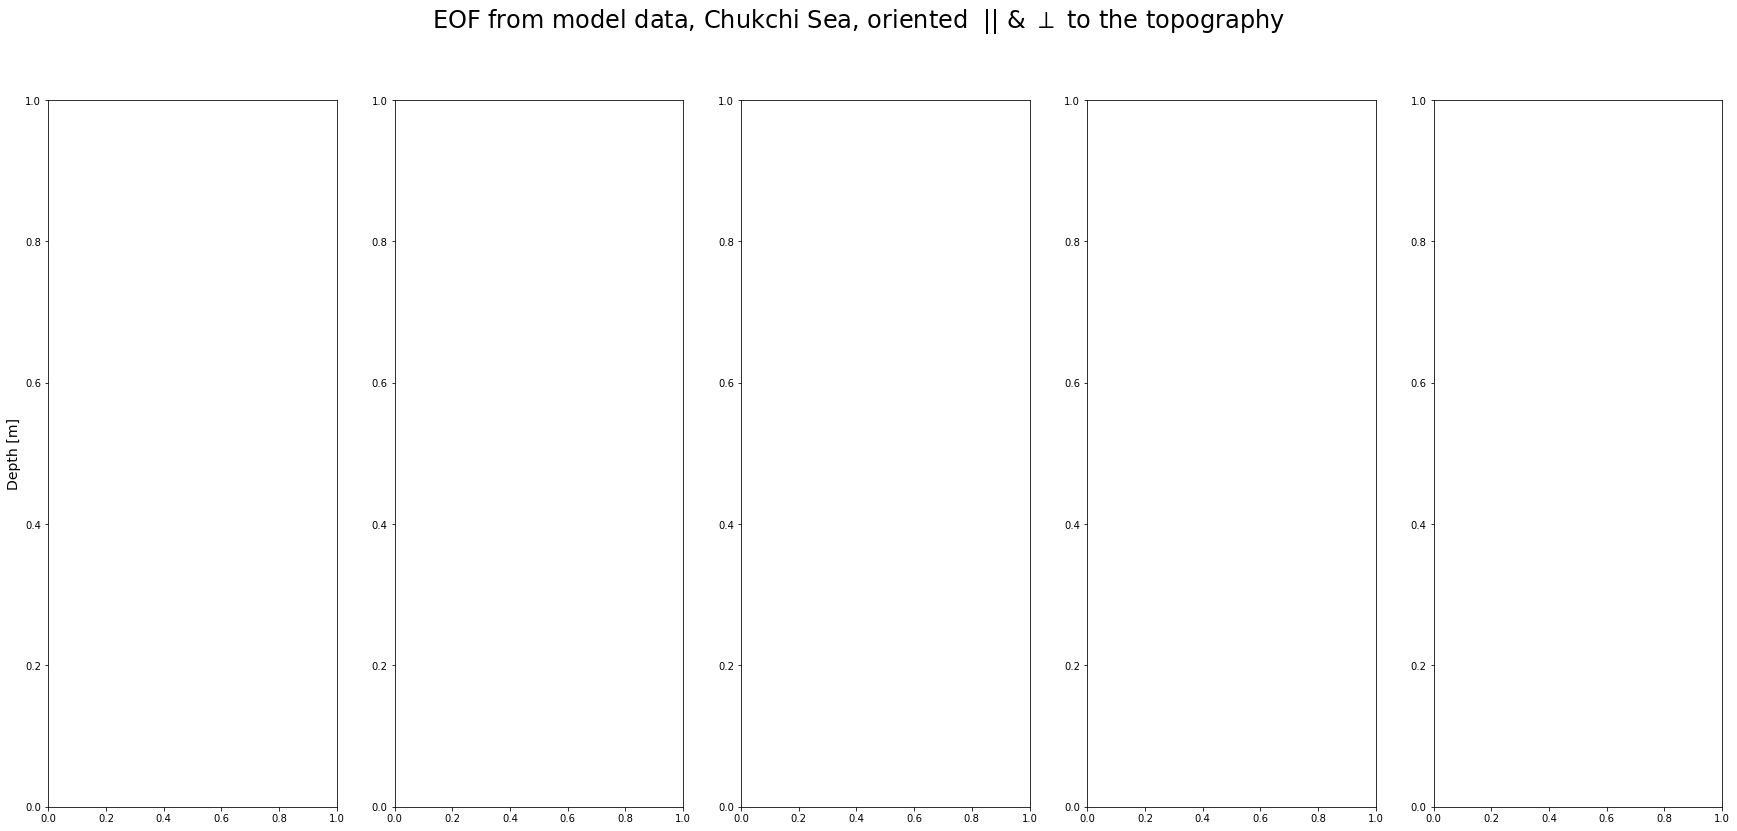

In [2]:
warnings.simplefilter("ignore")
fig, axes = plt.subplots(1,5,figsize = (30,13))
plt.suptitle('EOF from model data, Chukchi Sea, oriented  $||$ & $\perp$ to the topography', 
             horizontalalignment='center',
            fontsize=24)
axes[0].set_ylabel('Depth [m]', fontsize=14)

for axs, p in zip(axes.flat, range(len(chi))):
    pp = chi[p]
    print(pp[0], pp[1])    
    PC1p, PC1o, PC2p, PC2o, dypp, dypo, PVE1p, PVE1o, PVE2p, PVE2o = PCz_op(pp[0],pp[1])
        
    axs.plot(PC1p,dypp.depth, 'navy', label = f'EOF1$||$, PVE={PVE1p}%')
    axs.plot(PC1o,dypo.depth, 'cornflowerblue', label = f'EOF1$\perp$, PVE={PVE1o}%')
    axs.plot(PC2p,dypp.depth, 'navy', linestyle = '--', label = f'EOF2$||$, PVE={PVE2p}%')
    axs.plot(PC2o,dypo.depth, 'cornflowerblue', linestyle = '--', label = f'EOF2$\perp$, PVE={PVE2p}%')
    axs.axvline(0, color='k', linestyle = '--')
    axs.legend(frameon=False, fontsize=10, loc="upper left") 
    axs.invert_yaxis()
    axs.set_xlabel('Current speed [cm/s]', fontsize=14)

#fig.tight_layout()   

plt.savefig('EOF_chuckchi_mod_topo.pdf', dpi = 300)